#### Importownie bibliotek

In [84]:
import pandas as pd
import numpy as np
import pickle

import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV




import ipywidgets as widgets
from IPython.display import display, clear_output

#### Wczytanie dev_df z pliku

In [85]:
dev_df=pd.read_csv("../dfs/full_df.csv")
#dev_df=pd.read_csv("../dfs/dev_df.csv")

dev_df_ok = dev_df[dev_df['state'] == 0]

#x_dev=dev_df.drop(['Unnamed: 0','pledged_in_usd','percentage_of_money_collected','backers', 'state'], axis=1)

uplim_goal = 200000
uplim_pledged = 1000000

x_dev=dev_df.drop(['Unnamed: 0','pledged_in_usd','percentage_of_money_collected','backers', 'state'], axis=1)[dev_df['goal_in_usd'] <= uplim_goal][dev_df['pledged_in_usd'] <= uplim_pledged]

#y_dev=dev_df['state'][dev_df['goal_in_usd'] <= uplim_goal]
y_dev_reg = dev_df['pledged_in_usd'][dev_df['goal_in_usd'] <= uplim_goal][dev_df['pledged_in_usd'] <= uplim_pledged]
y_dev = y_dev_reg


/home/bartosz/miniconda3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


#### Reprezentacja x i y 

In [86]:
x_dev.head()

,main_cat_cat,country,duration,currency,goal_in_usd
0,80,21,30,13,500.00
1,54,7,30,5,3315.48
2,0,21,31,13,18000.00
3,154,21,45,13,60000.00
4,159,21,45,13,75000.00


In [87]:
y_dev.head()

0      575.00
1       33.15
2    20891.00
3        0.00
4    11734.01
Name: pledged_in_usd, dtype: float64

In [88]:
print(x_dev.shape)
print(y_dev.shape)

(361804, 5)
(361804,)


#### Podział próbek na treningowe i testowe

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x_dev, y_dev, test_size=0.18, random_state = 222)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(296679, 5)
(65125, 5)
(296679,)
(65125,)


In [90]:
x_train['goal_in_usd'].describe()

count    296679.000000
mean      14823.316706
std       25417.801698
min           0.010000
25%        2000.000000
50%        5062.780000
75%       15000.000000
max      200000.000000
Name: goal_in_usd, dtype: float64

In [91]:
y_train.describe()

count    296679.000000
mean       7250.782169
std       31966.872059
min           0.000000
25%          35.000000
50%         652.000000
75%        4101.000000
max      987384.200000
Name: pledged_in_usd, dtype: float64

#### Podanie parametrów do xgb.XGBRegressor

In [80]:
# params= {'objective': 'reg:squarederror'}

#### Wyliczenie modelu xgb.XGBRegressor

In [65]:
# %%time
# def test(params):
#     model = xgb.XGBRegressor(**params)
#     model.fit(x_train,y_train)
#     y_pred = model.predict(x_test)
    
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2score = r2_score(y_test, y_pred)
#     score = model.score(x_test,y_test)
    
#     return mse, mae, r2score, score, model

#### Wyniki

In [66]:
Saved = []

In [92]:
dm_train = xgb.DMatrix(x_train,y_train)
dm_test = xgb.DMatrix(x_test,y_test)

params3 = {"objective":"reg:squarederror", 'learning_rate': 0.2, "max_depth":5, 'min_child_weight':1, "booster":"gbtree", 'gamma': 0,'reg_alpha' : 0, 
           'importance_type':'gain','reg_lambda' : 1,'num_parallel_tree': 1, "n_jobs" : 4}
boosts3 = {"n_rounds":100}



def run_model3(button):
    #global time_model3
    #time_model3 = %timeit -n1 -r1 -o xgb.train(params3, dm_train, num_boost_round=boosts3['n_rounds'] )
    #global model3
    t0=time.time()

    #model3 = xgb.train(params3, dm_train, num_boost_round=boosts3['n_rounds'])
    global model3
    model3 = xgb.XGBRegressor(**params3,n_estimators=boosts3['n_rounds'] )
    #model3 = xgb.train(params3, dm_train, num_boost_round=boosts3['n_rounds'])
    model3.fit(x_train,y_train)
    tend = time.time()


    preds3 = model3.predict(x_test)
    predsTrain3 = model3.predict(x_train)
    global R2_score3
    R2_score3 = r2_score(y_test, preds3)
    #global mae3
    mae3 = mean_absolute_error(y_test,preds3)
    #global mse3
    mse3 = mean_squared_error(y_test, preds3)

    global score3train
    score3train = r2_score(y_train, predsTrain3)
    global train_time
    train_time = tend - t0


    #print(f'\nmodel3 train time = {time_model3.average} s')
    print(f'model3 score R2: {R2_score3}')
    print(f'model3 mean average error: {mae3}')
    print(f'model3 mean squared error: {mse3}')
    print(f'model TRAIN R2 score: {score3train}')
    print(f'Training time: {train_time}')
    
    #print('\n',model3cv)
    
def cv_model3(button):
    cvt0=time.time()

    model3cv = xgb.cv(params3, dm_train, num_boost_round=boosts3['n_rounds'], nfold=4, metrics=['mae','rmse'] )
    cvtend = time.time()
    
    rmse_val_train = model3cv['train-rmse-mean'].to_numpy()
    rmse_val_test = model3cv['test-rmse-mean'].to_numpy()
    
    mae_val_train = model3cv['train-mae-mean'].to_numpy()
    mae_val_test = model3cv['test-mae-mean'].to_numpy()
    
    
    plt.figure(figsize=(25,10))
    plt.subplot(1,2,2)
    plt.plot(mae_val_train)
    plt.plot(mae_val_test)
    plt.legend(['TRAIN MAE','TEST MAE'])
    #plt.show()
    
    plt.subplot(1,2,1)
    plt.plot(rmse_val_train)
    plt.plot(rmse_val_test)
    plt.legend(['TRAIN RMSE','TEST RMSE'])
    plt.show()
    

def cv_score(button):
    cvt0=time.time()
    model3 = xgb.XGBRegressor(**params3,n_estimators=boosts3['n_rounds'])

    score_val = np.mean(cross_val_score(model3, x_train, y_train, cv=4))
    print('CV score : ', score_val)
    

/home/bartosz/miniconda3/envs/ml_course/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


'SELECT MODEL PARAMETERS'

Boost rounds:   620 , Other parameters:  {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'booster': 'gbtree', 'gamma': 2.4000000000000004, 'reg_alpha': 1.2000000000000002, 'importance_type': 'gain', 'reg_lambda': 1.0, 'num_parallel_tree': 1, 'n_jobs': 4}


/home/bartosz/miniconda3/envs/ml_course/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


model3 score R2: 0.12479747204927993
model3 mean average error: 8424.895737540046
model3 mean squared error: 821344021.9273508
model TRAIN R2 score: 0.19101359502780746
Training time: 108.04087567329407


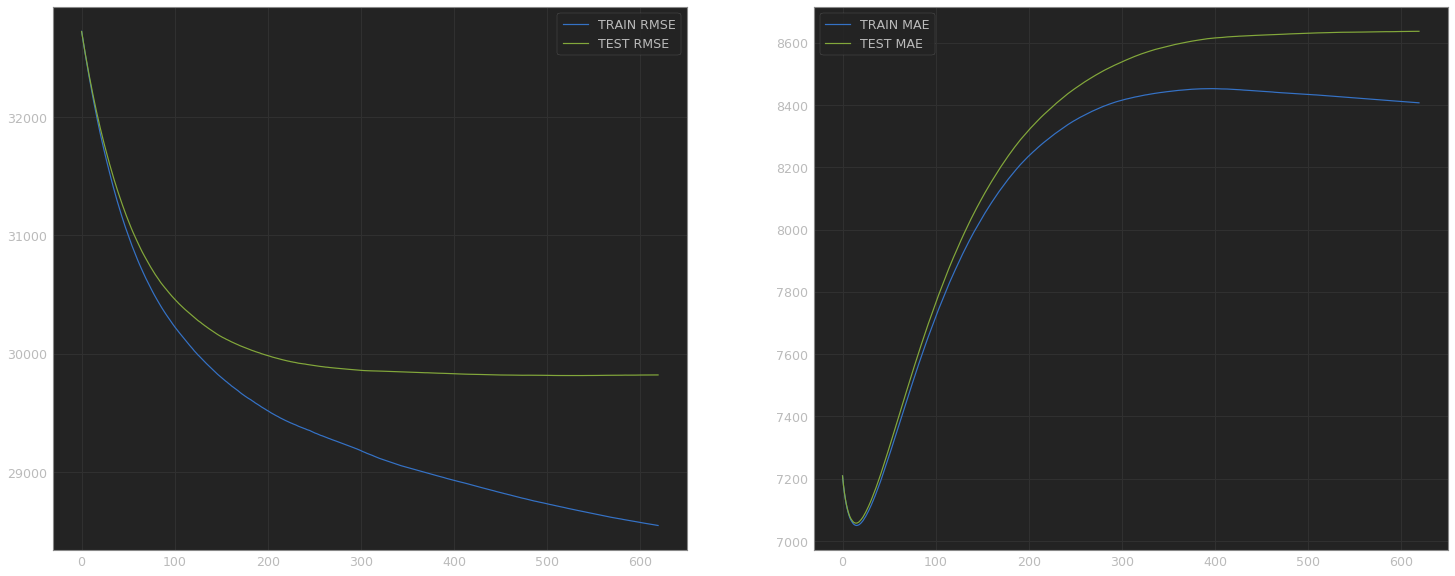

In [93]:
run_model_button = widgets.Button(description="Run Model 3")
run_model_button.on_click(run_model3)


cv_model_button = widgets.Button(description="Check CV (4-fold)")
cv_model_button.on_click(cv_model3)

######## number of boost rounds
boost_slider = widgets.IntSlider(100,10,50000,10)
boost_num = widgets.HBox([widgets.Label('Number of boost rounds:'),boost_slider])

######## number of parallel_trees

forest_slider = widgets.IntSlider(1,1,100)
forest_num = widgets.HBox([widgets.Label('Number of trees in forest:'),forest_slider])


####### learning_rate slider
learning_rate_slider = widgets.FloatSlider(value = 0.2, min = 0.01, max = 1.0, step = 0.01)
learnig_rate = widgets.HBox([widgets.Label('Learning rate (eta):'),learning_rate_slider])


######## tree depth
depth_slider = widgets.IntSlider(5,1,20,1)
depth = widgets.HBox([widgets.Label('Depth of single tree :'),depth_slider])

######## min_child_weight
child_slider = widgets.IntSlider(1,1,50,1)
min_child = widgets.HBox([widgets.Label('min child weight :'),child_slider])

######### booster type dropdown
boosters_list = ['gbtree','dart','linear']
booster_choice = widgets.Dropdown(options=boosters_list)
booster_menu = widgets.HBox([widgets.Label('Choose booster:'),booster_choice])


####### gamma slider
gamma_slider = widgets.FloatSlider(value = 0, min = 0.00, max = 20.0, step = 0.01)
gamma = widgets.HBox([widgets.Label('Gamma:'),gamma_slider])


####### alpha slider
alpha_slider = widgets.FloatSlider(value = 0, min = 0.00, max = 50.0, step = 0.01)
alpha_reg = widgets.HBox([widgets.Label('L1 Regularization (Alpha):'),alpha_slider])

####### lambda slider
lambda_slider = widgets.FloatSlider(value = 1.0, min = 0.00, max = 50.0, step = 0.01)
lambda_reg = widgets.HBox([widgets.Label('L2 Regularization (Lambda):'),lambda_slider])

######### booster type dropdown
importance_list = ["gain", "weight", "cover", "total_gain", "total_cover"]
importance_choice = widgets.Dropdown(options=importance_list)
importance_menu = widgets.HBox([widgets.Label('importance_type:'),importance_choice])



def params3_updater(button):
    boosts3['n_rounds'] =           boost_slider.value
    boosts3['num_parallel_tree'] =  forest_slider.value
    
    params3["booster"] =            booster_choice.value
    params3["learning_rate"] =      learning_rate_slider.value
    params3["max_depth"] =          depth_slider.value
    params3['min_child_weight'] =   child_slider.value
    params3["gamma"] =              gamma_slider.value
    params3["reg_lambda"] =         lambda_slider.value
    params3["reg_alpha"] =          alpha_slider.value
    params3['importance_type'] =    importance_choice.value
    clear_output()
    run_gui()
    print('Boost rounds:  ',boosts3['n_rounds'],', Other parameters: ',params3)
    
update_button = widgets.Button(description="Update params")
update_button.on_click(params3_updater)


def save_params(button):
    Saved.append({'ID': len(Saved),
                  'SCORE': R2_score3 ,
                  'TRAIN SCORE':score3train,
                  'TrAIN TIME' : train_time,
                  'num_parallel_tree':params3["num_parallel_tree"],
                  'n_rounds': boosts3['n_rounds'],
                  "booster": params3["booster"],
                  "learning_rate":params3["learning_rate"],
                  "max_depth":params3["max_depth"],
                  'min_child_weight':params3['min_child_weight'],
                  'gamma':params3["gamma"],
                  'reg_lambda':params3["reg_lambda"],
                  'reg_alpha':params3["reg_alpha"],
                  'importance_type':params3['importance_type']
                 })
    print('saved!')

save_button = widgets.Button(description="Save params and score")
save_button.on_click(save_params)

def show_Saved(button):
    clear_output()
    run_gui()
    for el in Saved:
        print(el)

show_button = widgets.Button(description="Show saved")
show_button.on_click(show_Saved)



def restore_saved(button):
    n = restore_number.value
    boosts3['n_rounds'] = Saved[n]['n_rounds']
    params3["booster"] = Saved[n]['booster']
    params3["num_parallel_tree"] = Saved[n]['num_parallel_tree']
    params3["learning_rate"] = Saved[n]['learning_rate']
    params3["max_depth"] = Saved[n]['max_depth']
    params3['min_child_weight'] = Saved[n]['min_child_weight']
    params3["gamma"] = Saved[n]['gamma']
    params3["reg_lambda"] = Saved[n]['reg_lambda']
    params3["reg_alpha"] = Saved[n]['reg_alpha']
    params3['importance_type'] = Saved[n]['importance_type']
    
    boost_slider.value          = Saved[n]['n_rounds'] 
    booster_choice.value        = Saved[n]['booster']
    forest_slider.value         = Saved[n]['num_parallel_tree']
    learning_rate_slider.value  = Saved[n]['learning_rate']
    depth_slider.value          = Saved[n]['max_depth']
    child_slider.value          = Saved[n]['min_child_weight']
    gamma_slider.value          = Saved[n]['gamma']
    lambda_slider.value         = Saved[n]['reg_lambda']
    alpha_slider.value          = Saved[n]['reg_alpha']
    importance_choice.value     = Saved[n]['importance_type']
    clear_output()
    run_gui()
    print('Boost rounds:  ',boosts3['n_rounds'],', Other parameters: ',params3)
    
restore_number = widgets.IntText(0)    

restore_button = widgets.Button(description="Restore saved")
restore_button.on_click(restore_saved)


cvscore_button = widgets.Button(description="cross_val_SCORE")
cvscore_button.on_click(cv_score)

    
def set_best_random(button):
    boosts3['n_rounds'] =          xgbr_search.best_params_['n_estimators']
    params3["booster"] =           xgbr_search.best_params_['booster']
    params3["num_parallel_tree"] = xgbr_search.best_params_['num_parallel_tree']
    params3["learning_rate"] =     xgbr_search.best_params_['learning_rate']
    params3["max_depth"] =         xgbr_search.best_params_['max_depth']
    params3['min_child_weight'] =  xgbr_search.best_params_['min_child_weight']
    params3["gamma"] =             xgbr_search.best_params_['gamma']
    params3["reg_lambda"] =        xgbr_search.best_params_['reg_lambda']
    params3["reg_alpha"] =         xgbr_search.best_params_['reg_alpha']
    
    boost_slider.value          = xgbr_search.best_params_['n_estimators'] 
    booster_choice.value        = xgbr_search.best_params_['booster']
    forest_slider.value         = xgbr_search.best_params_['num_parallel_tree']
    learning_rate_slider.value  = xgbr_search.best_params_['learning_rate']
    depth_slider.value          = xgbr_search.best_params_['max_depth']
    child_slider.value          = xgbr_search.best_params_['min_child_weight']
    gamma_slider.value          = xgbr_search.best_params_['gamma']
    lambda_slider.value         = xgbr_search.best_params_['reg_lambda']
    alpha_slider.value          = xgbr_search.best_params_['reg_alpha']
    clear_output()
    run_gui()
    print('Boost rounds:  ',boosts3['n_rounds'],', Other parameters: ',params3)

best_random_button = widgets.Button(description="Use best found random")
best_random_button.on_click(set_best_random)

######## GUI ##########

def run_gui():
    display('SELECT MODEL PARAMETERS')
    display(booster_menu,forest_num,boost_num,learnig_rate,depth,min_child,gamma,lambda_reg,alpha_reg,importance_menu)

    display(widgets.HBox([update_button,run_model_button,save_button,show_button]))
    display(widgets.HBox([restore_number, restore_button, cv_model_button]))
    display(widgets.HBox([best_random_button,cvscore_button]))



    

run_gui()

In [126]:
#{'main_cat_cat': LabelEncoder(), 'country': LabelEncoder(), 'currency': LabelEncoder(), 'state': LabelEncoder()}


## randomSearch CV

/home/bartosz/miniconda3/envs/ml_course/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'reg_lambda': 1.0, 'reg_alpha': 1.2000000000000002, 'objective': 'reg:squarederror', 'num_parallel_tree': 1, 'n_estimators': 620, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 2.4000000000000004, 'booster': 'gbtree'}
test score:  0.12930202630975154 




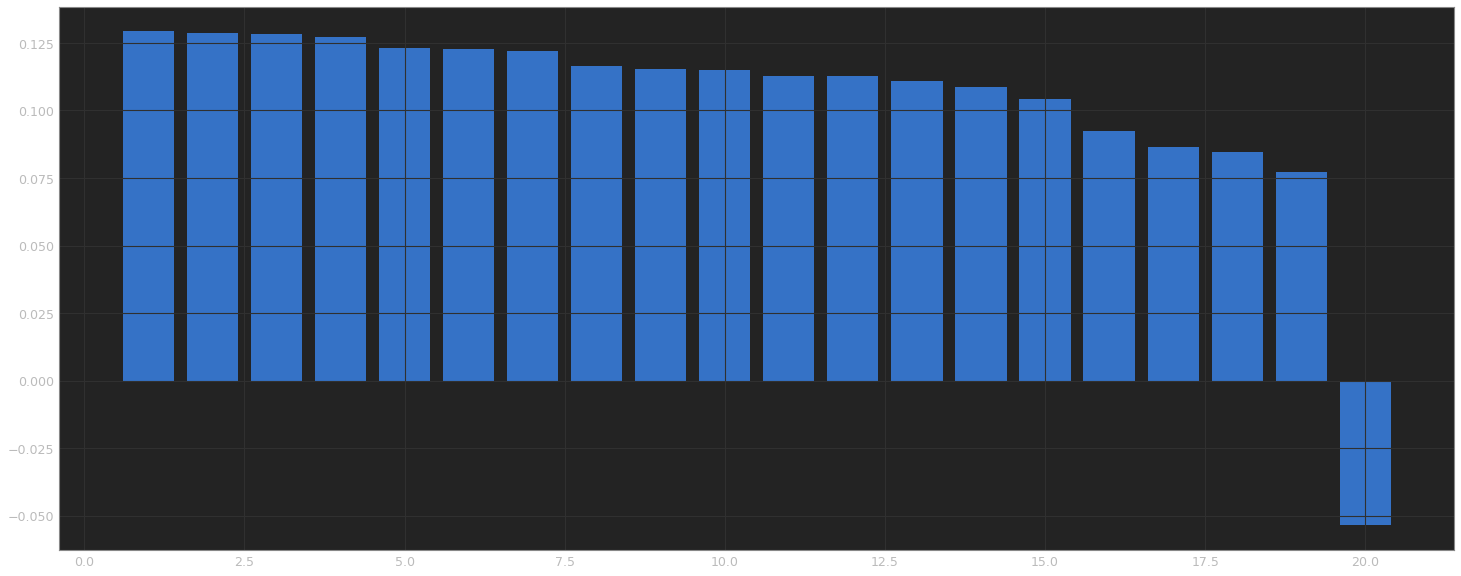

CPU times: user 2min 15s, sys: 653 ms, total: 2min 16s
Wall time: 47min 35s


In [94]:
%%time
Xgbreg = xgb.XGBRegressor()
#Xgbreg = xgb.XGBRFRegressor()

paramsRS = {"objective":["reg:squarederror"], 
            "n_estimators": range(20,1000,40),
             'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.07,0.08,0.1,0.12,0.15,0.15,0.2,0.22,0.25,0.27,0.3,0.35,0.4],
             "max_depth":range(2,8), 
             'min_child_weight':range(1,4,1), 
             "booster":["gbtree"],
             'gamma': np.arange(0.0,4,0.2),
             'reg_alpha' : np.arange(0.0,2,0.1), 
             'reg_lambda' : np.arange(0.0,3,0.1),
             'num_parallel_tree': [1]}
            

xgbr_search = RandomizedSearchCV(Xgbreg, param_distributions = paramsRS, cv= 4, n_iter= 20, n_jobs = 4)
xgbr_search.fit(x_train,y_train)
print(xgbr_search.best_params_)

print('test score: ',xgbr_search.best_score_,'\n\n')

plt.figure(figsize=(25,10))
plt.bar(xgbr_search.cv_results_['rank_test_score'],xgbr_search.cv_results_['mean_test_score'], data=xgbr_search.cv_results_['mean_fit_time'])
plt.grid(True)
plt.show()

#### Zapisanie modelu wyliczonego z dev_df

In [95]:
pkl_filename = "model_reg.pickle"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model3, file)

#### W celu pobrania modelu z pliku wystarczy tyle:

In [ ]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

#### Sprawdzenie czy się poprawnie otworzył

In [ ]:
pickle_model
y_pred = pickle_model.predict(x_test)
    
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2score = r2_score(y_test, y_pred)
score = pickle_model.score(x_train,y_train) 
mse, mae, r2score, score